In [1]:
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
%matplotlib inline

In [2]:
def func1(P,p,rho):
    gamma = 1.4 
    s = (gamma*p/rho)**(1/2)
    
    if p > P:
        return 2*s/(gamma-1)*((P/p)**((gamma-1)/(2*gamma))-1)
    else:
        return (P-p)/(rho*s)*((gamma+1)/(2*gamma)*P/p+(gamma-1)/(2*gamma))**(-1/2)

In [3]:
def func1_shtrih(P,p,rho):
    gamma = 1.4 
    s = (gamma*p/rho)**(1/2)
    
    if p > P:
        return s/(gamma*P)*(P/p)**((gamma-1)/(2*gamma))
    else:
        return ((gamma+1)*P/p+(3*gamma-1))/(4*gamma*rho*s)*((gamma+1)/(2*gamma)*P/p+(gamma-1)/(2*gamma))**(-3/2)

In [4]:
def initial_guess(Wl, Wr):
    d_l, u_l, p_l = Wl
    d_r, u_r, p_r = Wr
    c_l = (gamma*p_l/d_l)**(1/2)
    c_r = (gamma*p_r/d_r)**(1/2)
    P_pv = 0.5*(p_l+p_r)-0.125*(u_r-u_l)*(d_l+d_r)*(c_l+c_r)
    P_0 = max(TOL,P_pv)
    g_l = ((2/(gamma+1)/d_l)/((gamma-1)/(gamma+1)*p_l+P_0))**0.5
    g_r = ((2/(gamma+1)/d_r)/((gamma-1)/(gamma+1)*p_r+P_0))**0.5
    p_m = max(((g_l*p_l+g_r*p_r - (u_r-u_l))/(g_l+g_r)), TOL)
    
    
    return p_m
   


In [5]:
Wl = numpy.array([1.,0.,1.])
Wr = numpy.array([0.125,0., 0.1])
gamma = 1.4
TOL = 1e-6

In [6]:
z = 0
z += 5
print(z)

5


In [7]:
initial_guess(Wl, Wr)

0.31526852260996635

In [8]:
def Newton(Wl, Wr):
    d_l, u_l, p_l = Wl
    d_r, u_r, p_r = Wr
    i = 0
    change = 10.
    i_max = 100
    P_old = initial_guess(Wl, Wr)
    u_diff = u_r-u_l
    while change>= TOL and i <= i_max:
        P = P_old - (func1(P_old, p_l, d_l)+func1(P_old, p_r, d_r)+u_diff)/(func1_shtrih(P_old, p_l, d_l)\
                                                                     +func1_shtrih(P_old, p_r, d_r))
        change = abs(P- P_old)/(0.5*(P+P_old))
        
        P_old = P
    return P
    

In [10]:
def sample(Wl,cl,Wr,cr, p_m,u_m, s):
    d_l, u_l, p_l = Wl
    d_r, u_r, p_r = Wr
    if s <= u_m:
        if p_m <= p_l: #volna razr. sleva
            head_speed_l = u_l - c_l 
            if s <= head_speed_l: #sleva ot volni razr
                d = d_l
                u = u_l
                p = p_l
            else:
                c_m_l = c_l*(p_m/p_l)**((gamma-1)/(2*gamma))
                tail_speed_l = u_m - c_m_l 
                
                if s>= tail_speed_l:
                    d = d_l*(p_m/p_l)**(1./gamma)
                    u = u_m
                    p = p_m
                else: #veer prandtl'a maiera
                    u = 2./(gamma+1)*(c_l+ u_l*0.5*(gamma-1)+s)
                    c = u - s
                    d = d_l*(c/c_l)**(2./(gamma-1))
                    p = p_l*(c/c_l)**(2*gamma/(gamma-1))
        else:
            # sleva -- skaчок
            shock_ratio = p_m/p_l
            s_l = u_l - c_l*((gamma+1)/(2*gamma)*shock_ratio+(gamma-1)/(2*gamma))**0.5
            
            if s <= s_l: #sleva ot skaчка
                d = d_l
                u = u_l
                p = p_l
            else:#mezdu skaчком i kontaktnim razrivom
                d = d_l*(shock_ratio+(gamma-1)/(gamma+1))/((gamma-1)/(gamma+1)*shock_ratio+1.)
                u = u_m
                p = p_m
                
    else: #sprava ot razriva
        if p_m > p_r:
            shock_ratio = p_m/p_r
            s_r = u_r +c_r*(((gamma+1)*shock_ratio+(gamma-1))/(2*gamma))**0.5
            
            if s >= s_r:
                d = d_r
                u = u_r
                p = p_r
            else: # mezdu skaчком i kont razrivom
                d = d_r*(shock_ratio+(gamma-1)/(gamma+1))/((gamma-1)/(gamma+1)*shock_ratio+1.)
                u = u_m
                p = p_m
        else: #sprava volna
            head_speed_r = u_r + c_r
            if s >= head_speed_r:
                d = d_r
                u = u_r
                p = p_r
            else:
                c_m_r = c_r*(p_m/p_r)**((gamma-1)/(2*gamma))
                tail_speed_r = u_m + c_m_r
                if s <= tail_speed_r:
                    d = d_r*(p_m/p_r)**(1/gamma)
                    u = u_m
                    p = p_m
                else:#veer
                    u = 2./(gamma+1)*(-c_r+(gamma-1)*0.5*u_r+s)
                    c = s - u
                    d = d_r*(c/c_r)**(2/(gamma-1))
                    p = p_r*(c/c_r)**(2*gamma/(gamma-1))
    
    return d,u,p
                

In [11]:
length = 1.
N = 1001
x_dis = 0.5 
TOL = 1e-6


t_out = 0.25
d_l, u_l, p_l = [1.0, 0, 1.0]
d_r, u_r, p_r = [0.125, 0, 0.1]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [12]:

dx = length/(N-1)
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
print(W_init)
P = Newton(Wl, Wr)
U = 0.5*(u_l+u_r+func1(P, p_r, d_r)\
           -func1(P, p_l, d_l))


S = numpy.zeros_like(x)
S[:] = (x[:]-x_dis)/t_out


[[ 1.     0.     1.   ]
 [ 1.     0.     1.   ]
 [ 1.     0.     1.   ]
 ..., 
 [ 0.125  0.     0.1  ]
 [ 0.125  0.     0.1  ]
 [ 0.125  0.     0.1  ]]


In [14]:
sol = numpy.zeros((N-1,3))
for i , s in enumerate(S):
    sol[i] = sample(Wl,c_l,Wr,c_r, P,U, s)

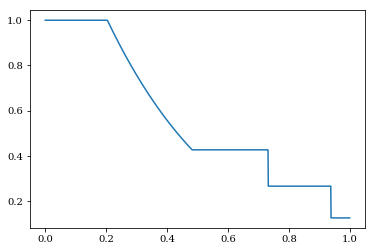

In [15]:
pyplot.plot(x,sol[:,0])

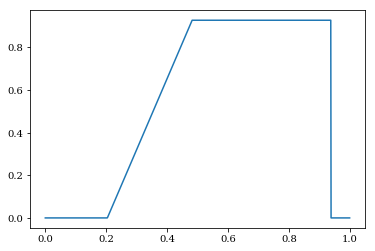

In [16]:
pyplot.plot(x,sol[:,1])

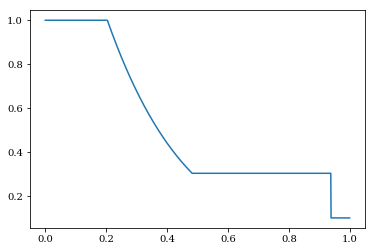

In [17]:
pyplot.plot(x,sol[:,2])

In [18]:
#Test №2
t_out = 0.15
d_l, u_l, p_l = [1.0, -2., 0.4]
d_r, u_r, p_r = [1.0, 2., 0.4]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [19]:
dx = length/(N-1)
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
P = Newton(Wl, Wr)
U = 0.5*(u_l+u_r+func1(P, p_r, d_r)\
           -func1(P, p_l, d_l))


S = numpy.zeros_like(x)
S[:] = (x[:]-x_dis)/t_out

In [21]:
initial_guess(Wl, Wr)

1e-06

In [22]:
sol = numpy.zeros((N-1,3))
for i , s in enumerate(S):
    sol[i] = sample(Wl,c_l,Wr,c_r, P,U, s)

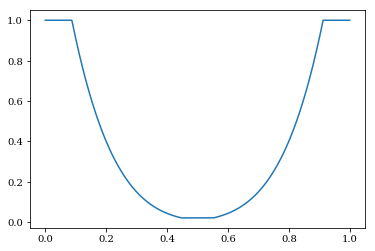

In [26]:
pyplot.plot(x,sol[:,0]);

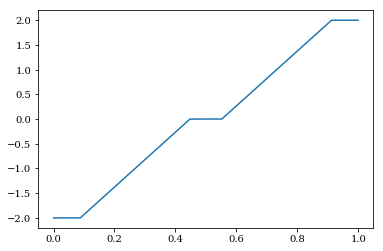

In [27]:
pyplot.plot(x,sol[:,1]);

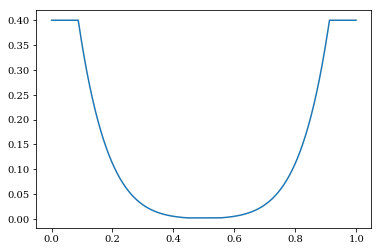

In [28]:
pyplot.plot(x,sol[:,2]);

In [29]:
#Test №3
t_out =  0.012
d_l, u_l, p_l = [1.0, 0, 1000]
d_r, u_r, p_r = [1.0, 0, 0.01]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [30]:
dx = length/(N-1)
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [31]:
P = Newton(Wl, Wr)
U = 0.5*(u_l+u_r+func1(P, p_r, d_r)\
           -func1(P, p_l, d_l))


S = numpy.zeros_like(x)
S[:] = (x[:]-x_dis)/t_out

In [32]:
initial_guess(Wl, Wr)

464.10769951484457

In [33]:
sol = numpy.zeros((N-1,3))
for i , s in enumerate(S):
    sol[i] = sample(Wl,c_l,Wr,c_r, P,U, s)

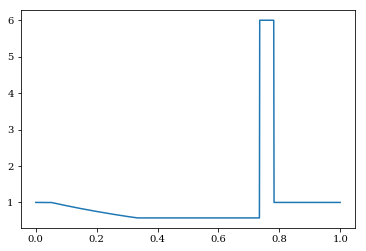

In [34]:
pyplot.plot(x,sol[:,0]);

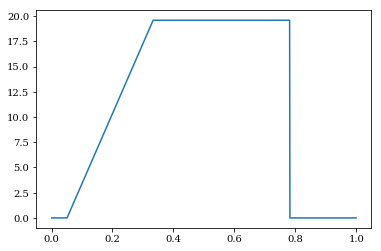

In [35]:
pyplot.plot(x,sol[:,1]);

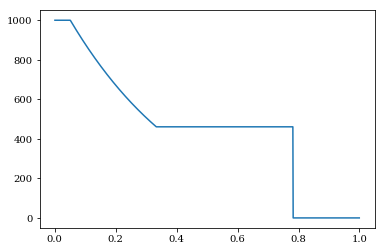

In [36]:
pyplot.plot(x,sol[:,2]);

In [37]:
#Test №4
t_out =  0.035
d_l, u_l, p_l = [1.0, 0, 0.01]
d_r, u_r, p_r = [1.0, 0, 100.]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [38]:
dx = length/(N-1)
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [39]:
P = Newton(Wl, Wr)
U = 0.5*(u_l+u_r+func1(P, p_r, d_r)\
           -func1(P, p_l, d_l))


S = numpy.zeros_like(x)
S[:] = (x[:]-x_dis)/t_out

In [40]:
sol = numpy.zeros((N-1,3))
for i , s in enumerate(S):
    sol[i] = sample(Wl,c_l,Wr,c_r, P,U, s)

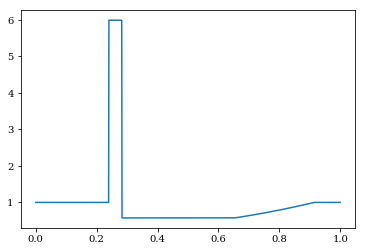

In [41]:
pyplot.plot(x,sol[:,0]);

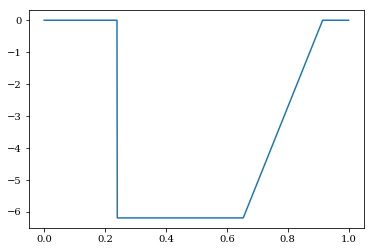

In [42]:
pyplot.plot(x,sol[:,1]);

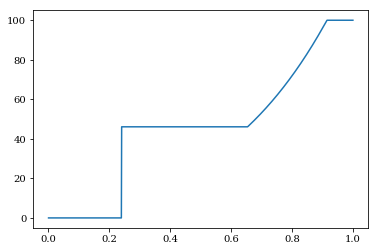

In [43]:
pyplot.plot(x,sol[:,2]);

In [44]:
#Test №5
t_out =  0.035
d_l, u_l, p_l = [5.99924, 19.5975, 460.894]
d_r, u_r, p_r = [5.99242, -6.19633, 46.095]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [45]:
dx = length/(N-1)
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [46]:
P = Newton(Wl, Wr)
U = 0.5*(u_l+u_r+func1(P, p_r, d_r)\
           -func1(P, p_l, d_l))


S = numpy.zeros_like(x)
S[:] = (x[:]-x_dis)/t_out

In [47]:
sol = numpy.zeros((N-1,3))
for i , s in enumerate(S):
    sol[i] = sample(Wl,c_l,Wr,c_r, P,U, s)

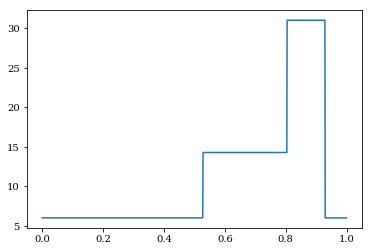

In [48]:
pyplot.plot(x,sol[:,0]);

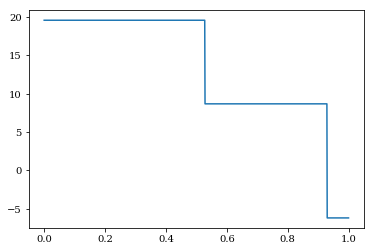

In [49]:
pyplot.plot(x,sol[:,1]);

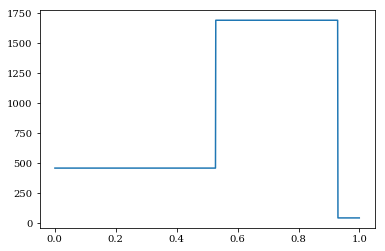

In [50]:
pyplot.plot(x,sol[:,2]);

In [96]:
# Test-1
length = 1.
N = 1001
x_dis = 0.5 
TOL = 1e-6


t_out = 0.25
d_l, u_l, p_l = [1.0, 0, 1.0]
d_r, u_r, p_r = [0.125, 0, 0.1]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [155]:
dx = length/(N-1)
sigma1 = 0.08
dt = sigma1*dx
nt = t_out/dt
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [156]:
print(W_init.shape)
W_init_trans = numpy.transpose(W_init)

(1000, 3)


In [157]:
print(W_init_trans.shape)

(3, 1000)


In [113]:
def f(u):
    
    """
    Functia potokov konservativnih peremenih
    """
    u1 = u[0]
    u2 = u[1]
    u3 = u[2]
    
    
    return numpy.array([u2, u2*u2/u1+(gamma-1)*(u3-0.5*u2*u2/u1),
                      (u3+(gamma-1)*(u3-0.5*u2*u2/u1))*u2/u1])

In [114]:
def f1(u):
    "Functia perehoda ot primitivnih k konservativnim peremennim"
    Rho = u[0]
    v = u[1]
    p = u[2]
    e = p/((gamma-1)*Rho)
    eT = e+0.5*v*v
    return numpy.array([Rho, Rho*v, Rho*eT]) 

In [158]:
u = f1(W_init_trans) #flux variables 


u_star = numpy.zeros((len(u),len(u[0])))
u_n = numpy.zeros_like(u)      
    #copy the initial u array into each row of our new array
print(u.shape,u_star.shape)


(3, 1000) (3, 1000)


In [159]:
print(u)

[[ 1.     1.     1.    ...,  0.125  0.125  0.125]
 [ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 2.5    2.5    2.5   ...,  0.25   0.25   0.25 ]]


In [144]:
def Godunov(u,nt,dt,dx):
    u_plus = numpy.zeros_like(u)
    u_minus = numpy.zeros_like(u)
    flux = numpy.zeros_like(u)
    for n in range(0,int(nt)):
        #print('next step')
    
        u_n = u.copy() 
        #print(n)
    
    
   
    
    
    
        u_plus[:,:-1] = u[:,1:] # Can't do i+1/2 indices, so cell boundary
        u_minus = u.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (f(u_minus) + 
                      f(u_plus) + 
                      dx / dt * (u_minus - u_plus))
        u_n[:,1:-1] = u[:,1:-1] + dt/dx*(flux[:,:-2]-flux[:,1:-1])
        u_n[:,0] = u[:,0]
        u_n[:,-1] = u[:,-1]
        u = u_n.copy()
    return u

In [118]:
def f3(u):
    u1 = u[0]
    u2 = u[1]
    u3 = u[2]
   
    return numpy.array([u1, u2/u1, (u3/u1-0.5*u2*u2/u1/u1)*((gamma-1)*u1)])


In [160]:
"polucenie resenia"
U2 = Godunov(u,nt,dt,dx)



D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [161]:
z3 = f3(U2)
"zapolnenie massiva"

p3 = numpy.arange(len(u[0]))
p3 = z3[2,:]

rho3 = numpy.arange(len(u[0]))
rho3 = z3[0,:]
v3 = numpy.arange(len(u[0]))
v3 = z3[1,:]

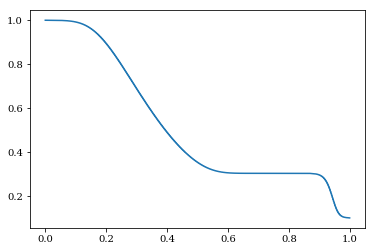

In [162]:
pyplot.plot(x,p3);

In [163]:
#Test №2
t_out = 0.15
d_l, u_l, p_l = [1.0, -2., 0.4]
d_r, u_r, p_r = [1.0, 2., 0.4]
Wl = numpy.array([d_l, u_l, p_l])
Wr = numpy.array([d_r, u_r, p_r])



c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [164]:
dx = length/(N-1)
sigma1 = 0.08
dt = sigma1*dx
nt = t_out/dt
x = numpy.linspace(0,1,N)[1:] - 0.5*dx
W_init = numpy.zeros((N-1, 3))
W_init[:(N-1)/2] = Wl
W_init[(N-1)/2:] = Wr

D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [165]:
print(W_init.shape)
W_init_trans = numpy.transpose(W_init)

(1000, 3)


In [166]:
u = f1(W_init_trans) #flux variables 


u_star = numpy.zeros((len(u),len(u[0])))
u_n = numpy.zeros_like(u)      
    #copy the initial u array into each row of our new array
print(u.shape,u_star.shape)

(3, 1000) (3, 1000)


In [167]:
"polucenie resenia"
U2 = Godunov(u,nt,dt,dx)



D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
D:\helpprogramms\Python\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [168]:
z3 = f3(U2)
"zapolnenie massiva"

p3 = numpy.arange(len(u[0]))
p3 = z3[2,:]

rho3 = numpy.arange(len(u[0]))
rho3 = z3[0,:]
v3 = numpy.arange(len(u[0]))
v3 = z3[1,:]

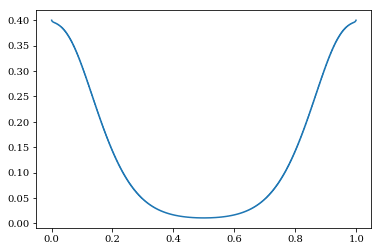

In [169]:
pyplot.plot(x,p3);

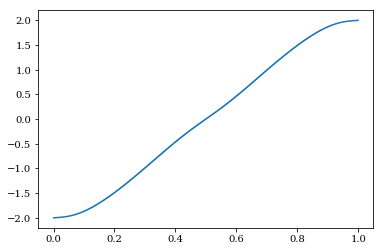

In [170]:
pyplot.plot(x,v3);